# Data Exploration

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_csv("NQ_from_2000.csv", sep= ";")

In [7]:
df.head()

Date   Time    Open    High     Low   Close  Up  Down  PLOT1  PLOT2
0  01/03/2000  01:00  6975.5  6977.0  6975.5  6975.5   3     0    0.0    0.0
1  01/03/2000  02:00  6977.5  6979.5  6977.5  6979.5   2     0   -1.0   -1.0
2  01/03/2000  03:00  6979.5  6993.5  6979.5  6987.5  21     0   -1.0   -1.0
3  01/03/2000  04:00  6986.5  6994.5  6984.5  6992.5  16     0   -1.0   -1.0
4  01/03/2000  05:00  6994.5  6999.5  6993.5  6999.5  19     0   -1.0   -1.0

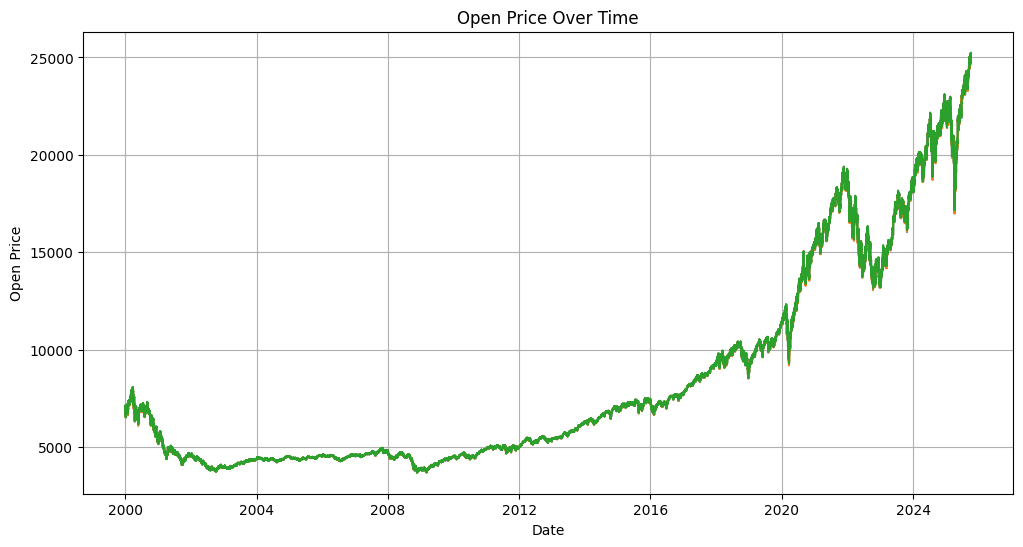

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'])
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['High'])
plt.title('Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()

In [9]:
High_low_delta = np.mean(df["High"] - df["Low"])
High_low_delta

np.float64(20.215157563803075)

In [10]:
High_low_delta = np.mean(df["Open"] - df["Close"])
High_low_delta 

np.float64(-0.12723588455867998)

# Quant Strategies

## Hypothesis

We assume
- Instant trade
- No fees on trades
- We can buy any percentage of the index fund
- No impact on market
- No arbitrage
- Unlimited Capital


## 1.Benchmark

Time in the market beats timing in the market 

The benchmark buys 100 $ of the index fund each first of the month at 12

In [11]:
# Filter data
benchmark_trades = df[(df['Time'] == '12:00') & (df['Date'].dt.day == 1)]

# Compute the performance
investment = 0
units = 0

for _, trade in benchmark_trades.iterrows():
    # Buy 100 dollar worth at the open price
    units += 100 / trade["Open"] 
    investment +=  100
    
# Compute final value using the last close price
final_value = units * df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100
PnL = (final_value - investment)

print(f"Total investment: ${investment:,.2f}")

print(f"Final value: ${final_value:,.2f}")
print(f"PnL : ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total investment: $19,900.00
Final value: $78,233.12
PnL : $58,333.12
Total return: 293.13%


## 2. Dummy strategy

Very basic momentum based strat 

- If for 3 consecutive hours the price rises by more than the average High-Low delta, we buy $100
- If for 5 consecutive hours price falls by more than the average High-Low delta, we sell $100

I think I saw this in an insta reel about Citadelle

In [12]:
# Initialize variables
investment = 0
units = 0
consecutive_up = 0
consecutive_down = 0
volume =0

# Iterate through data
for i in range(1, len(df)):
    price_change = df['Close'].iloc[i] - df['Close'].iloc[i-1]
    High_low_delta = df['High'].iloc[i-1] - df['Low'].iloc[i-1]

    # Check for upward momentum
    if price_change > High_low_delta:
        consecutive_up += 1
        consecutive_down = 0
    # Check for downward momentum
    elif price_change < -High_low_delta:
        consecutive_down += 1
        consecutive_up = 0
    else:
        consecutive_up = 0
        consecutive_down = 0
    
    # Buy condition: 3 consecutive up hours
    if consecutive_up >= 3:
        units += 100 / df['Close'].iloc[i]
        volume += 100
        investment += 100
        consecutive_up = 0
    
    # Sell condition: 5 consecutive down hours
    if consecutive_down >= 5 and units > 0:
        sell_amount = min(100, units * df['Close'].iloc[i])
        units -= sell_amount / df['Close'].iloc[i]
        investment -= sell_amount
        consecutive_down = 0

# Calculate final results
final_value = units * df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100 if investment != 0 else 0
PnL = final_value - investment

print(f"Total Volume: ${volume:,.2f}")
print(f"Total investment: ${investment:,.2f}")
print(f"Final value: ${final_value:,.2f}")
print(f"PnL: ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total Volume: $2,100.00
Total investment: $2,100.00
Final value: $9,643.65
PnL: $7,543.65
Total return: 359.22%


Let's try this strat but over the past month only

In [13]:
# Initialize variables

month_df = df[df["Time"] >= "15/09/2025"]

investment = 0
units = 0
consecutive_up = 0
consecutive_down = 0
volume = 0

# Iterate through data (use month_df)
for i in range(1, len(month_df)):
    price_change = month_df['Close'].iloc[i] - month_df['Close'].iloc[i-1]
    High_low_delta = month_df['High'].iloc[i-1] - month_df['Low'].iloc[i-1]

    # Check for upward momentum
    if price_change > High_low_delta:
        consecutive_up += 1
        consecutive_down = 0
    # Check for downward momentum
    elif price_change < -High_low_delta:
        consecutive_down += 1
        consecutive_up = 0
    else:
        consecutive_up = 0
        consecutive_down = 0
    
    # Buy condition: 3 consecutive up hours
    if consecutive_up >= 3:
        units += 100 / month_df['Close'].iloc[i]
        investment += 100
        consecutive_up = 0
    
    # Sell condition: 5 consecutive down hours
    if consecutive_down >= 5 and units > 0:
        sell_amount = min(100, units * month_df['Close'].iloc[i])
        units -= sell_amount / month_df['Close'].iloc[i]
        investment -= sell_amount
        volume += 100
        consecutive_down = 0

# Calculate final results using month_df
final_value = units * month_df['Close'].iloc[-1]
total_return = (final_value - investment) / investment * 100 if investment != 0 else 0
PnL = final_value - investment

print(f"Total Volume: ${volume:,.2f}")
print(f"Total investment: ${investment:,.2f}")
print(f"Final value: ${final_value:,.2f}")
print(f"PnL: ${PnL:,.2f}")
print(f"Total return: {total_return:.2f}%")

Total Volume: $0.00
Total investment: $900.00
Final value: $4,047.51
PnL: $3,147.51
Total return: 349.72%


Surprisingly it works 

However ! Relatively no trades were made and we didn't sell anything 
So I think this would work better in a HFT 

## 3 Machine Learning 

### A. Feature engineering